In [2]:
import time
import logging
import sys
import gzip

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import scipy.stats as stats
from scipy.signal import savgol_filter

from collections import Counter

%matplotlib inline

pd.set_option('display.max_colwidth', None)

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 5

In [110]:
#load in hotspots
samples = ['data_2021-08-27/ky08', 'data_2021-08-27/ky10', 'data_2021-08-27/ky06', 'data_2021-11-10/ky04', 'data_2021-08-27/ky17', 'data_2021-08-27/ky18', 'data_2021-08-27/ky11', 'data_2021-08-27/ky13']
#samples = ['data_2021-08-27/ky08', 'data_2021-08-27/ky10', 'data_2021-08-27/ky17', 'data_2021-08-27/ky18']
lorax_sigs = []

for i, x in enumerate(samples):
    df = pd.read_csv(x+'/hotspots.new.clean.gtf')
    print(i)
    lorax_sigs.append(df)

0
1
2
3
4
5
6
7


In [55]:
#load in preprocessed mnetseq dfs
samples = ['ky08', 'ky10', 'ky17', 'ky18']
dfs = []

for i, x in enumerate(samples):
    df = pd.read_csv('data_2021-08-27/'+x+'/'+x+'_info.new.clean.gtf')
    print(i)
    dfs.append(df)

0
1
2
3


In [124]:
l = lorax_sigs[1]
l = l[l.gene_type == 'protein_coding']

In [57]:
#3' lorax hotspot motif

from Bio import motifs
from Bio.Seq import Seq
import logomaker

from Bio import SeqIO

def revcomp(seq):
	seq=seq.replace('A','X')
	seq=seq.replace('T','A')
	seq=seq.replace('X','T')
	seq=seq.replace('C','X')
	seq=seq.replace('G','C')
	seq=seq.replace('X','G')
	return seq[::-1]

fasta = '/mnt/brick1/ref/human/genome.fa'
records = SeqIO.to_dict(SeqIO.parse(open(fasta), 'fasta'))

In [146]:
seq_dfs=[]

for df in lorax_sigs[4:8]:
    print(len(df))
    
    df = df[df.gene_type == 'protein_coding']
    df = df[0:40000]
    tempdf = df.copy()
    
    searchsize = 10
    prime3_seq = []
    prime5_seq = []

    for cs, p3s, p5s, strand in zip(df['chr_1'], df['3prime'], df['5prime'], df['read_strand_1']):

        if cs in records:
            seq3 = str(records[cs][max(p3s-searchsize, 0):p3s+searchsize].seq).upper()
            seq5 = str(records[cs][max(p5s-searchsize, 0):p5s+searchsize].seq).upper()

            if strand == '-':
                seq3 = revcomp(seq3)
                seq5 = revcomp(seq5)

            prime3_seq.append(seq3)
            prime5_seq.append(seq5)
        else: 
            prime3_seq.append('')
            prime5_seq.append('')

    tempdf['3prime_seq'] = prime3_seq
    tempdf['5prime_seq'] = prime5_seq
    
    seq_dfs.append(tempdf)

334111
371837
1045531
171325


n=40000


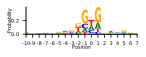

n=40000


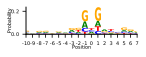

n=40000


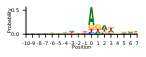

n=40000


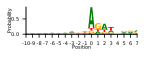

In [147]:
l = 2*searchsize

for i, lorax_sig in enumerate(seq_dfs):
    
    instances = []
    
    for s in lorax_sig['3prime_seq']:
        if (isinstance(s, str)) and ('N' not in s) and (len(s) >= l):
            instances.append(Seq(s))

    print("n=" + str(len(instances)))

    m = motifs.create(instances)

    m = m.counts
    m = pd.DataFrame.from_dict(m, orient='columns')

    m = logomaker.transform_matrix(m, from_type='counts', to_type='information')

    m.index = list(range(-searchsize,searchsize))
    
    fig, ax = plt.subplots(1,1,figsize=[2,.5])

    
    logo = logomaker.Logo(             m,
                          shade_below=.5,
                          fade_below=.5,
                          ax=ax,
                          font_name='Arial Rounded MT Bold')

    # style using Logo methods
    logo.style_spines(visible=False)
    logo.style_spines(spines=['left', 'bottom'], visible=True)
    logo.style_xticks(rotation=0, fmt='%d', anchor=0)

    # style using Axes methods
    logo.ax.set_ylabel("Probability", labelpad=-1)
    logo.ax.set_xlabel("Position", labelpad=-1)
    logo.ax.set_xlim(-10, 7)
    #logo.ax.set_ylim(0, .8)
    
    #if i >=2:
    #    logo.ax.set_ylim(0, .5)
        
    plt.savefig('svg/'+str(i)+'logo.svg', format="svg")
    
    plt.show()

In [ ]:
#how many T

In [120]:
howmany = []

for i, lorax_sig in enumerate(seq_dfs):
    
    count = 0
    total = 0
    
    for s in lorax_sig['3prime_seq']:
        if (isinstance(s, str)) and ('N' not in s) and (len(s) >= l):
            if s[9:10] == 'T':
                count += 1
            total += 1
            
    print(count*100/total)
    howmany.append(count*100/total)
    

59.87
69.16345817290865
60.005
59.345
9.26
11.06
33.26
32.8


In [119]:
len(s)

20

In [106]:
#calculate rt mispriming
percents = []

for s in seq_dfs:
    count = 0

    for each in s['3prime_seq'].str[10:16]:
        if each == 'AGATCG':
            count += 1

    print(100*count/len(seq_dfs[0]))
    percents.append(count*100/len(seq_dfs[0]))

1.55
0.8
0.02
0.98
1.95
2.24
2.95
2.98


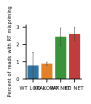

In [139]:
leg = ['WT LORAX', 'KO LORAX', 'WT LORAX', 'KO LORAX', 'WT NET', 'KO NET', 'WT NET', 'KO NET']
pdf = pd.DataFrame(zip(leg, percents), columns = ['variable', 'value'])

data = pdf
x='variable'
y='value'

plt.figure(figsize = (1, 1))

ax = sns.barplot(data=data, x=x, y=y, errwidth=.5, capsize=.05)
sns.despine()

ax.set_xlabel('')
ax.set_ylabel('Percent of reads with RT mispriming')

plt.savefig('svg/mispriming.svg', format="svg")

plt.show()

In [ ]:
#drop duplicates logo analysis

In [128]:
#clean data - run to drop duplicates

keepme = ['protein_coding', '.']
clean_dfs = []

for df in dfs:
    print(len(df))
    
    reads_to_remove = df[~df['gene_type'].isin(keepme)]['read_id']
    cdf = df[~df.read_id.isin(reads_to_remove)]
    cdf = cdf.drop_duplicates('read_id')
    
    print(len(cdf))
          
    cdf = cdf.drop_duplicates(['5prime', '3prime'])
    
    print(len(cdf))
          
    clean_dfs.append(cdf)

6888297
3690214
606113
27990357
15719468
5936019
33457091
24103950
18618182
42318663
31091610
24130895


In [130]:
sizes = []

for c in clean_dfs:
    temp = c[c.gene_type == 'protein_coding']
    temp = c.groupby(['3prime']).size().reset_index().sort_values(0,ascending=False)
    temp = c.drop_duplicates('3prime').merge(temp)
    
    sizes.append(temp.sort_values(0, ascending=False))

In [131]:
seq_dfs=[]

for df in sizes:
    print(len(df))
    
    df = df[df.gene_type == 'protein_coding']
    df = df[0:50000]
    tempdf = df.copy()
    
    searchsize = 10
    prime3_seq = []
    prime5_seq = []

    for cs, p3s, p5s, strand in zip(df['chr_1'], df['3prime'], df['5prime'], df['read_strand_1']):

        if cs in records:
            seq3 = str(records[cs][max(p3s-searchsize, 0):p3s+searchsize].seq).upper()
            seq5 = str(records[cs][max(p5s-searchsize, 0):p5s+searchsize].seq).upper()

            if strand == '-':
                seq3 = revcomp(seq3)
                seq5 = revcomp(seq5)

            prime3_seq.append(seq3)
            prime5_seq.append(seq5)
        else: 
            prime3_seq.append('')
            prime5_seq.append('')

    tempdf['3prime_seq'] = prime3_seq
    tempdf['5prime_seq'] = prime5_seq
    
    seq_dfs.append(tempdf)

539853
5344130
14683244
18956715


n=50000


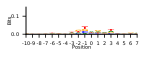

n=50000


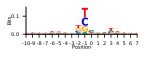

n=50000


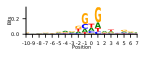

n=50000


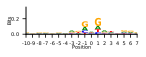

In [136]:
l = 2*searchsize

for i, lorax_sig in enumerate(seq_dfs):
    
    instances = []
    
    for s in lorax_sig['3prime_seq']:
        if (isinstance(s, str)) and ('N' not in s) and (len(s) >= l):
            instances.append(Seq(s))

    print("n=" + str(len(instances)))

    m = motifs.create(instances)

    m = m.counts
    m = pd.DataFrame.from_dict(m, orient='columns')

    m = logomaker.transform_matrix(m, from_type='counts', to_type='information')

    m.index = list(range(-searchsize,searchsize))
    
    fig, ax = plt.subplots(1,1,figsize=[2,.5])

    
    logo = logomaker.Logo(             m,
                          shade_below=.5,
                          fade_below=.5,
                          ax=ax,
                          font_name='Arial Rounded MT Bold')

    # style using Logo methods
    logo.style_spines(visible=False)
    logo.style_spines(spines=['left', 'bottom'], visible=True)
    logo.style_xticks(rotation=0, fmt='%d', anchor=0)

    # style using Axes methods
    logo.ax.set_ylabel("Bits", labelpad=-1)
    logo.ax.set_xlabel("Position", labelpad=-1)
    logo.ax.set_xlim(-10, 7)
    logo.ax.set_ylim(0, .15)
    
    if i >=2:
        logo.ax.set_ylim(0, .35)
    
    plt.savefig('svg/'+str(i)+'logo.svg', format="svg")
    
    plt.show()